In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

**Extracting Image Features**

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 17s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# Store features in pickel
    
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

**Loading the Caption Data**

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

**Process text data**

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [10]:
# preprocess the text
clean(mapping)

**store the preprocessed captions into a list**

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [12]:
len(all_captions)

40455

**processing the text data**

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

8485

In [15]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Train Test Split**

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0


**Model Creation**

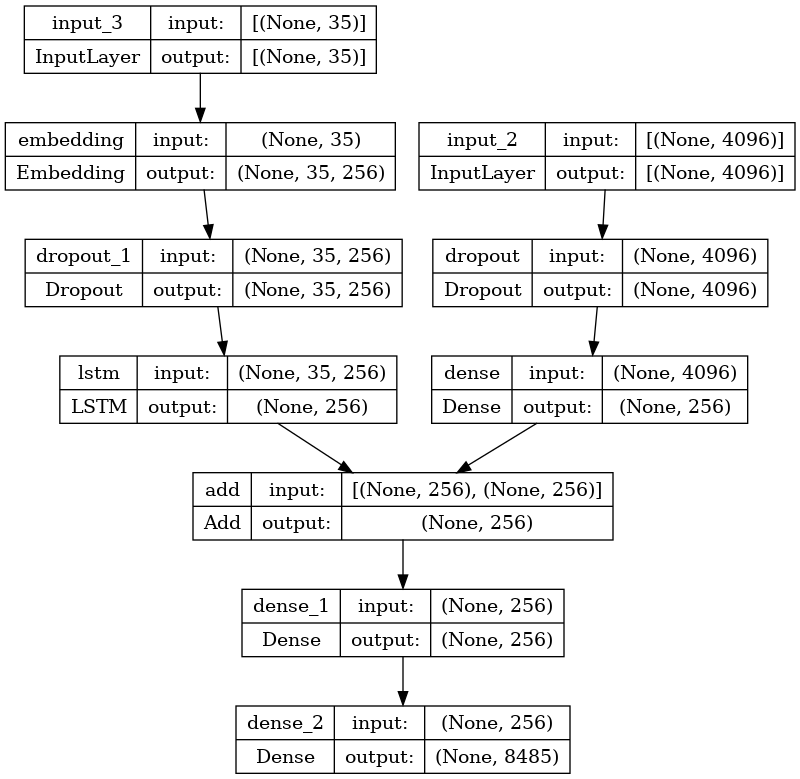

In [18]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [19]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 65s 286ms/step - loss: 5.9291


In [20]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [22]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

**validate the data using BLEU Score**

In [23]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.030197
BLEU-2: 0.030197
BLEU-1: 0.082085
BLEU-2: 0.082085
BLEU-1: 0.058816
BLEU-2: 0.058816
BLEU-1: 0.063928
BLEU-2: 0.063928
BLEU-1: 0.049787
BLEU-2: 0.049787
BLEU-1: 0.049787
BLEU-2: 0.049787
BLEU-1: 0.053473
BLEU-2: 0.053473
BLEU-1: 0.052998
BLEU-2: 0.052998
BLEU-1: 0.052631
BLEU-2: 0.052631
BLEU-1: 0.040762
BLEU-2: 0.040762
BLEU-1: 0.043440
BLEU-2: 0.043440
BLEU-1: 0.045806
BLEU-2: 0.045806
BLEU-1: 0.046101
BLEU-2: 0.046101
BLEU-1: 0.046355
BLEU-2: 0.046355
BLEU-1: 0.049787
BLEU-2: 0.049787
BLEU-1: 0.049787
BLEU-2: 0.049787
BLEU-1: 0.046943
BLEU-2: 0.046943
BLEU-1: 0.048423
BLEU-2: 0.048423
BLEU-1: 0.051115
BLEU-2: 0.051115
BLEU-1: 0.048558
BLEU-2: 0.048558
BLEU-1: 0.052215
BLEU-2: 0.052215
BLEU-1: 0.053300
BLEU-2: 0.053300
BLEU-1: 0.053142
BLEU-2: 0.053142
BLEU-1: 0.051905
BLEU-2: 0.051905
BLEU-1: 0.051819
BLEU-2: 0.051819
BLEU-1: 0.051739
BLEU-2: 0.051739
BLEU-1: 0.050718
BLEU-2: 0.050718
BLEU-1: 0.050684
BLEU-2: 0.050684
BLEU-1: 0.050653
BLEU-2: 0.050653
BLEU-1: 0.0497

**Visualize the Results**

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq endseq


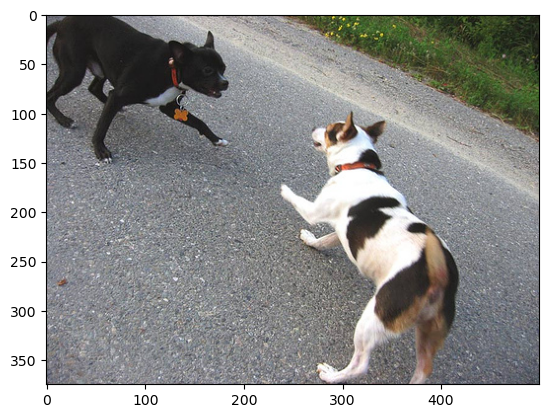

In [25]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq brown dog chases the water from sprinkler on lawn endseq
startseq brown dog plays with the hose endseq
startseq brown dog running on lawn near garden hose endseq
startseq dog is playing with hose endseq
startseq large brown dog running away from the sprinkler in the grass endseq
--------------------Predicted--------------------
startseq endseq


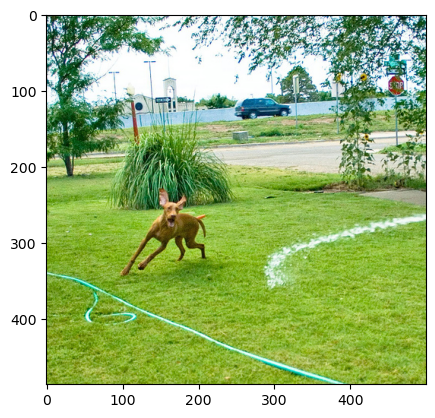

In [26]:
generate_caption('1019077836_6fc9b15408.jpg')